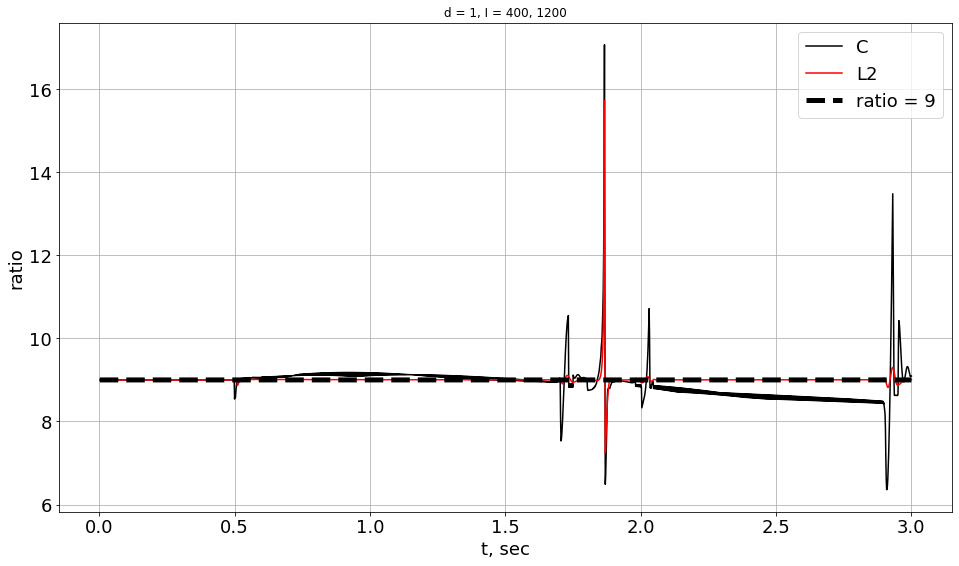

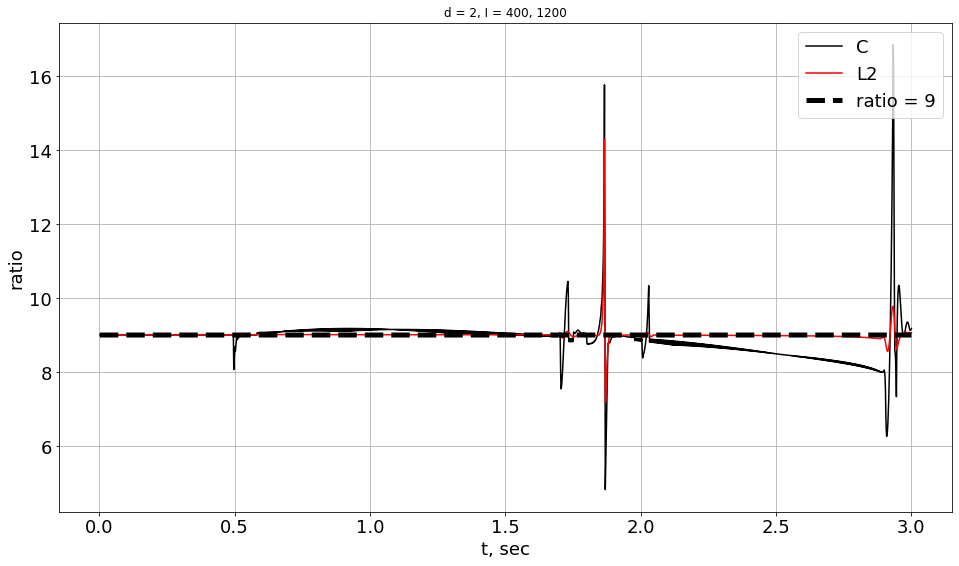

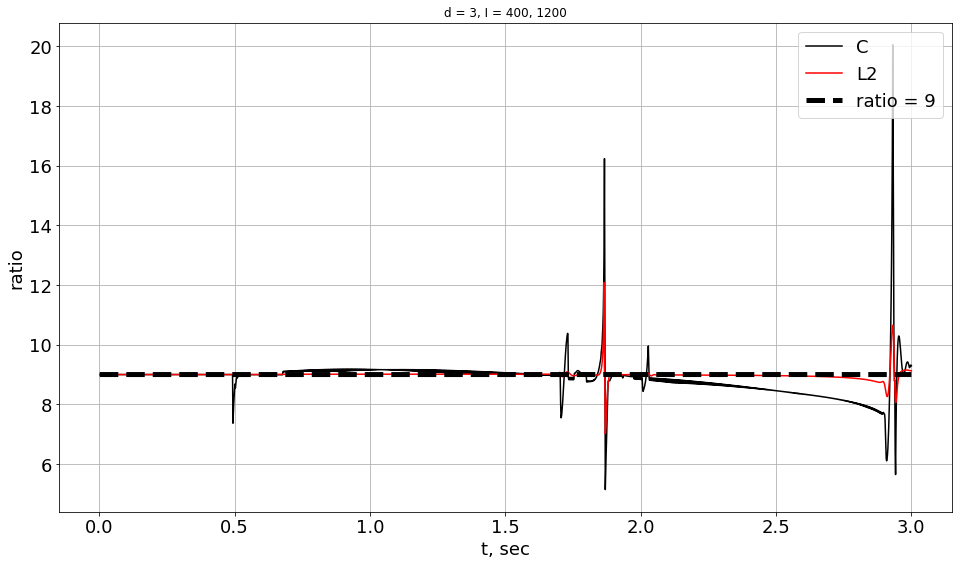

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import os
from numba import njit

def v0(r, a, b) : 
    if (r > a) and (r < b) : 
        return np.exp((-4*(2*r-(a+b))**2) / ((b-a)**2 - (2*r - (a+b))**2))
    else : 
        return 0
    


def solver(rmin, rmax, T, c, a, b, d, I, C) : 
    h = (rmax - rmin) / I
    r = np.zeros(I+2)
    for i in range(len(r)) : 
        r[i] = rmin + (i - 0.5) * h
    tau = C*h/c
    rr = lambda i: rmin + (i - 0.5)*h
    
    if (C > 1) : 
        print('C must be <= 1') 
    
    if ((int(T/tau)+1) % 10 == 1):
        t = np.linspace(0,T, int(T/tau)+1)
    else:
        t = np.linspace(0,T, int(T/tau)+2)
        
        
    
    u = np.zeros((len(t), len(r)))
    
    for i in range(len(r)) : 
        u[0, i] = v0(r[i], a, b)
        
    
    for i in range(1, len(r)-1) : 
        u[1, i] = u[0, i] + 1/2 * tau**2*c**2/(r[i]**(d-1) * h)*(rr(i+0.5)**(d-1)* (u[0, i+1] - u[0, i])/h - rr(i-0.5)**(d-1) * (u[0, i] - u[0, i-1])/h)
    u[1, -1] = u[0, -1] + 0  
    for n in range(1, len(t) - 1) : 
        for i in range(1, len(r) - 1) :
            u[n+1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2/(r[i]**(d-1) * h)*(rr(i+0.5)**(d-1)* (u[n, i+1] - u[n, i])/h - rr(i-0.5)**(d-1) * (u[n, i] - u[n, i-1])/h)
        u[n+1, 0] = u[n+1, 1]
        u[n+1, -1] = u[n+1, -2] 
        
        
    return u, r, t


def draw(u, r, t, d) : 
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    camera = Camera(fig)
    for i in range(len(t)) : 
        ax.plot(r, u[i, :], linestyle = 'None', marker = 'o', color = 'black', markersize = 5)
        camera.snap()
        plt.legend(['u(r)'], loc = 'upper right', fontsize = 18)
        plt.xlabel('r', fontsize = 18)
        plt.ylabel('u', fontsize = 18)
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title("d = " + str(d))
        
    animation = camera.animate()
    os.chdir(os.getcwd() + "\outData")
    animation.save('d = ' + str(d) + '.gif', writer='PillowWriter', fps = 30)
    os.chdir(os.getcwd().replace("\outData", "")) 
    
def checkConvergence(un1, tn1, rn1, un2, tn2, rn2, un3, tn3, rn3, d, I, rmin, rmax) : 
    
    y = np.array([])
    tIndex2 = [i for i in range(0,len(tn2),3)]
    tIndex3 = [i for i in range(0,len(tn3),9)]
    rIndex2 = [i for i in range(2,len(rn2),3)]
    rIndex3 = [i for i in range(5,len(rn3),9)]
    newu1 = un1[:, 1:-1]
    newu2 = getNewU(un2, tIndex2, rIndex2)
    newu3 = getNewU(un3, tIndex3, rIndex3)
    
    yy = np.array([])
    h = (rmax - rmin) / I
    for i in range(1, len(tn1)) : 
        y = np.append(y, np.max(np.abs(newu1[i] - newu2[i]))/np.max(np.abs(newu2[i] - newu3[i])))
        yy = np.append(yy, np.sqrt(np.sum(h**d * np.abs(newu1[i] - newu2[i])**2)) / np.sqrt(np.sum(h**d * np.abs(newu2[i] - newu3[i])**2)))
    
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    a9 = np.zeros(len(tn1[1:])) + 9
    ax.plot(tn1[1:], y, linestyle = '-', marker = 'None', color = 'black', label = 'C')
    ax.plot(tn1[1:], yy, linestyle = '-', marker = 'None', color = 'red', label = 'L2')
    ax.plot(tn1[1:], a9, linestyle = '--', marker = 'None', color = 'black', label = 'ratio = 9', linewidth = 5)

    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title("d = " + str(d) + ', I = 200, 600, 1800')
    plt.legend(loc = 'upper right', fontsize = 18)
    plt.xlabel('t, sec', fontsize = 18)
    plt.ylabel('ratio', fontsize = 18)
        
    os.chdir(os.getcwd() + "\convergence")
    name = str(d) + '.png'
    plt.savefig(fname = name)
    os.chdir(os.getcwd().replace("\convergence", "")) 


def getNewU(u,tIndex,rIndex):
    newU = np.zeros((len(tIndex), len(rIndex)))
    for n in range(len(tIndex)):
        for i in range(len(rIndex)):
            newU[n,i] = u[tIndex[n], rIndex[i]]
    return newU

def U(x, a, b) : 
    return v0(x, a, b)
    
def analytical(r, t, c, d, a, b) : 
    return r**((1-d)/2) * U(c*t-r, a, b)

def dUdr(x, a, b) : 
    return -16*(b-a)**2 *(2*x-a-b)/((b-a)**2 - (2*x-a-b)**2)**2 * U(x, a, b)

def danalyticaldr(r, t, c, d, a, b) :  
    return (1-d)/2 * r**(-(1+d)/2) * U(c*t - r, a, b) - r**((1-d)/2) * dUdr(c*t-r, a, b)

def f(r, t, a, b, c, d) : 
    return c**2 * (d-1)*(d-3)*U(c*t - r, a, b)/(4 * r**((d+3)/2))


def analyticalSolver(rmin, rmax, T, c, a, b, d, I, C) : 
    h = (rmax - rmin) / I
    r = np.zeros(I+2)
    for i in range(len(r)) : 
        r[i] = rmin + (i - 0.5) * h
    tau = C*h/c
    rr = lambda i: rmin + (i - 0.5)*h
    
    if (C > 1) : 
        print('C must be <= 1') 
    
    if ((int(T/tau)+1) % 10 == 1):
        t = np.linspace(0,T, int(T/tau)+1)
    else:
        t = np.linspace(0,T, int(T/tau)+2)
        
    u = np.zeros((len(t), len(r)))
    
    for i in range(len(r)) : 
        u[0, i] = r[i]**((1-d)/2) * U(-r[i], a, b)
        
    
    for i in range(len(r)) : 
        u[1, i] = r[i]**((1-d)/2) * U(c*tau-r[i], a, b) 
    
    for n in range(1, len(t) - 1) : 
        for i in range(1, len(r) - 1) :
            u[n+1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2/(r[i]**(d-1) * h)*(rr(i+0.5)**(d-1)* (u[n, i+1] - u[n, i])/h - rr(i-0.5)**(d-1) * (u[n, i] - u[n, i-1])/h)
            if d == 2 : 
                u[n+1, i] = u[n+1, i] + tau**2 * f(r[i], t[n], a, b, c, d)
                #u[n+1, i] = u[n+1, i] + tau**2 * c**2 * (d-1)*(d-3)*u[n, i]/(4 * r[i]**((d+3)/2))
        u[n+1, 0] = u[n+1, 1] - h*danalyticaldr(rmin, t[n+1], c, d, a, b)
        u[n+1, -1] = u[n+1, -2] + h*danalyticaldr(rmax, t[n+1], c, d, a, b)
        
        
    return u, r, t

def checkAnalyticalConvergence(ua1, ra1, ta1, ua2, ra2, ta2, d, I, rmin, rmax) : 
    tIndex2 = [i for i in range(0,len(ta2),3)]
    rIndex2 = [i for i in range(2,len(ra2),3)]
    newua2 = getNewU(ua2, tIndex2, rIndex2)
    newua1 = ua1[:, 1:-1]
    ua = np.zeros((len(ta1), len(ra1)))
    
    for n in range(len(ta1)) : 
        for i in range(len(ra1)) : 
            ua[n, i] = analytical(ra1[i], ta1[n], c, d, a, b)
            
    newua = ua[:, 1:-1]
    
    y = np.array([])
    yy = np.array([])
    h = (rmax - rmin) / I
    for i in range(1, len(ta1)) :
        if (np.isclose(np.max(np.abs(newua1[i] - newua[i])), 0, atol = 1e-07)) or (np.isclose(np.max(np.abs(newua2[i] - newua[i])), 0, atol = 1e-07)) : 
            y = np.append(y, 9)
        else : 
            y = np.append(y, np.max(np.abs(newua1[i] - newua[i]))/np.max(np.abs(newua2[i] - newua[i])))
            
        if (np.isclose(np.sqrt(np.sum(h**d * np.abs(newua1[i] - newua[i])**2)), 0, atol = 1e-07)) or (np.isclose(np.sqrt(np.sum(h**d * np.abs(newua2[i] - newua[i])**2)), 0, atol = 1e-07)) : 
            yy = np.append(yy, 9)
        else : 
            yy = np.append(yy, np.sqrt(np.sum(h**d * np.abs(newua1[i] - newua[i])**2)) / np.sqrt(np.sum(h**d * np.abs(newua2[i] - newua[i])**2)))
            
            
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    a9 = np.zeros(len(ta1[1:])) + 9
    ax.plot(ta1[1:], y, linestyle = '-', marker = 'None', color = 'black', label = 'C')
    ax.plot(ta1[1:], yy, linestyle = '-', marker = 'None', color = 'red', label = 'L2')
    ax.plot(ta1[1:], a9, linestyle = '--', marker = 'None', color = 'black', label = 'ratio = 9', linewidth = 5)
    
    
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title("d = " + str(d) + ', I = 400, 1200')
    plt.legend(loc = 'upper right', fontsize = 18)
    plt.xlabel('t, sec', fontsize = 18)
    plt.ylabel('ratio', fontsize = 18)
        
    os.chdir(os.getcwd() + "\convergence")
    name = 'analytical ' + str(d) + '.png'
    plt.savefig(fname = name)
    os.chdir(os.getcwd().replace("\convergence", "")) 


rmin = 0.1
rmax = 1.9
c = 1.5
a = 0.6
b = 1.2
C = 0.5
T = 3
I = 200

for d in range(1, 4) : 
    #un1, rn1, tn1 = solver(rmin, rmax, T, c, a, b, d, I, C)
    #un2, rn2, tn2 = solver(rmin, rmax, T, c, a, b, d, 3*I, C)
    #un3, rn3, tn3 = solver(rmin, rmax, T, c, a, b, d, 9*I, C)
    ua1, ra1, ta1 = analyticalSolver(rmin, rmax, T, c, a, b, d, 2 * I, C)
    ua2, ra2, ta2 = analyticalSolver(rmin, rmax, T, c, a, b, d, 3 * 2 * I, C)
    
    #checkConvergence(un1, tn1, rn1, un2, tn2, rn2, un3, tn3, rn3, d, I, rmin, rmax)
    checkAnalyticalConvergence(ua1, ra1, ta1, ua2, ra2, ta2, d, I, rmin, rmax)
    
    #draw(un1, rn1, tn1, d)
    
    
    